In [1]:
import os
import datetime as dt
from pathlib import Path
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

### Step 0. 데이터 불러오고 열어보기

In [2]:
data_path = Path(os.getenv("HOME")+'/aiffel/yoochoose-data/ml-1m')
train_path = data_path / 'ratings.dat'

In [3]:
def load_data(data_path: Path, nrows = None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0,1,2,3],
                      dtype={0:np.int32, 1:np.int32, 2:np.int32},
                      nrows=nrows)
    data.columns = ['UserId','ItemId','Rating','Time']
    return data

데이터를 보면  
- SessionID를 포함하지 않고 있으며 대신 UserID 정보가 있다.
- Rating 정보가 포함되어 있다. 

In [4]:
data = load_data(train_path, None)
# data를 id와 time 순으로 정렬
data.sort_values(['UserId', 'Time'], inplace=True)

In [5]:
data.head(10)

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
36,1,1836,5,978300172
3,1,3408,4,978300275
7,1,2804,5,978300719
47,1,1207,4,978300719
0,1,1193,5,978300760


In [6]:
data.drop(['Rating'], axis=1, inplace=True)

In [7]:
data.sample(5)

,UserId,ItemId,Time
82017,543,550,976215314
970728,5849,1263,957766098
957172,5776,2391,961023198
958463,5786,1198,958143251
804716,4818,750,962923141


In [8]:
print("User 수 : ", data['UserId'].nunique())
print("Item 수 : ", data["UserId"].nunique())

User 수 :  6040
Item 수 :  6040


한 UserID가 가지고 있는 row의 개수를 파악해보자.

In [9]:
userid_length = data.groupby('UserId').size()
print("userid 마다 가지고 있는 row의 수\n\n",userid_length)

userid 마다 가지고 있는 row의 수

 UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64


userid를 좀 더 알아보자.

In [10]:
print(" 중앙값 : ", userid_length.median(),"\n 평균값 : ", userid_length.mean())
print(" 최소값 : ", userid_length.min(), "\n 최대값 : ", userid_length.max())

 중앙값 :  96.0 
 평균값 :  165.5975165562914
 최소값 :  20 
 최대값 :  2314


In [11]:
print("0.999분위수 : ", userid_length.quantile(0.999))

0.999분위수 :  1343.181000000005


In [12]:
sum(userid_length.values > 1343)

7

In [13]:
print(" data 개수가 1343개 이상인 userid \n", list(userid_length[userid_length > 1343].index[:]))

 data 개수가 1343개 이상인 userid 
 [889, 1181, 1680, 1941, 3618, 4169, 4277]


평균적으로 한 아이디당 165개의 영화에 rating을 하였고 0.999분위수 안에  
포함된 분포를 확인해보면 1343개의 영화를 넘지 않는다.  
따라서 1343개 보다 많은 영화에 평점을 매긴 userid를 살펴볼 필요가 있다.

In [14]:
data_longest = data[data["UserId"].isin([889, 1181, 1680, 1941, 3618, 4169, 4277])]

In [15]:
data_longest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11885 entries, 137631 to 713774
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   UserId  11885 non-null  int32
 1   ItemId  11885 non-null  int32
 2   Time    11885 non-null  int64
dtypes: int32(2), int64(1)
memory usage: 278.6 KB


In [16]:
data_longest.groupby(["UserId"]).count()["ItemId"]

UserId
889     1518
1181    1521
1680    1850
1941    1595
3618    1344
4169    2314
4277    1743
Name: ItemId, dtype: int64

In [17]:
import seaborn as sns

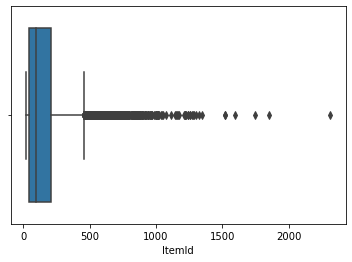

In [18]:
sns.boxplot(data.groupby(["UserId"]).count()["ItemId"])

In [19]:
length_count = userid_length.groupby(userid_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()

In [20]:
length_percent_cumsum_999=length_percent_cumsum[length_percent_cumsum < 0.999]

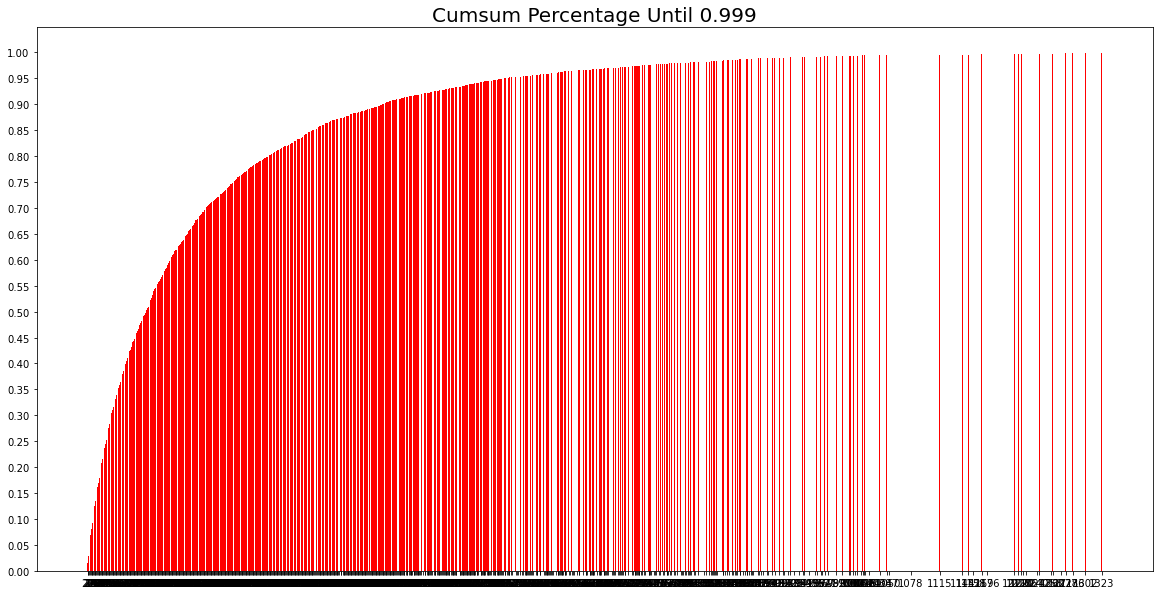

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

모델 학습에 큰 영향을 끼치지 않을 것으로 판단하여 모든 id

In [22]:
data.groupby("UserId").count()

,ItemId,Time
UserId,,
1,53,53
2,129,129
3,51,51
4,21,21
5,198,198
...,...,...
6036,888,888
6037,202,202
6038,20,20


### Step 1. 데이터 전처리

In [23]:
data.groupby("Time").count()

,UserId,ItemId
Time,,
956703932,1,1
956703954,2,2
956703977,2,2
956704056,5,5
956704081,1,1
...,...,...
1046454320,1,1
1046454338,1,1
1046454443,1,1


In [24]:
time_list = sorted(data["Time"].unique())

In [25]:
id_list = sorted(data["UserId"].unique())

Text(0.5, 1.0, 'User evaluation activity over time')

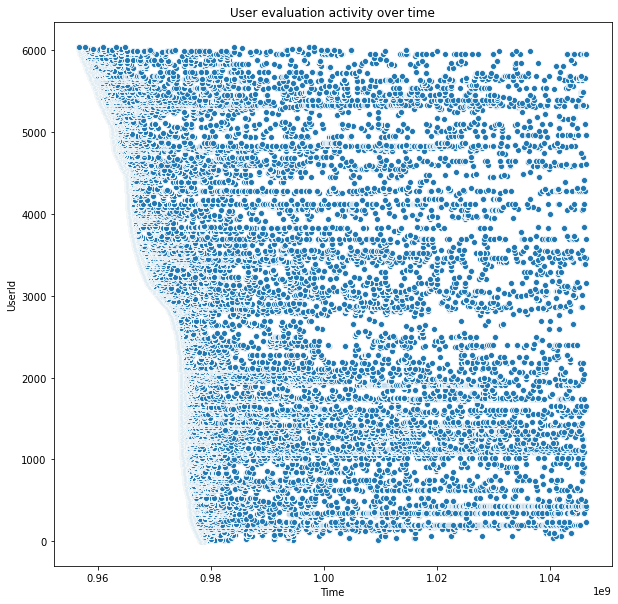

In [85]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=data["Time"], y=data['UserId'])
plt.title("User evaluation activity over time")

In [27]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

956703932
1046454590


In [28]:
dt.timedelta(1).total_seconds()

86400.0

In [29]:
latest - dt.timedelta(1).total_seconds()

1046368190.0

In [30]:
data.groupby('UserId')['Time'].max()

UserId
1       978824351
2       978300174
3       978298504
4       978294282
5       978246585
          ...    
6036    956755196
6037    956801840
6038    956717204
6039    956758029
6040    998315055
Name: Time, Length: 6040, dtype: int64

In [31]:
dt_end = (dt.datetime(1970, 1, 1) + dt.timedelta(seconds=data["Time"].max()))

In [32]:
dt_start = (dt.datetime(1970, 1, 1)+dt.timedelta(seconds=data["Time"].min()))

In [33]:
dt_day = (dt.datetime(1970, 1, 1)+dt.timedelta(seconds=978300019))

In [34]:
dt_day

datetime.datetime(2000, 12, 31, 22, 0, 19)

In [35]:
dt_end , dt_start

(datetime.datetime(2003, 2, 28, 17, 49, 50),
 datetime.datetime(2000, 4, 25, 23, 5, 32))

가장 최근의 약 한달 데이터만을 이용하여 학습한다.  
학습에 사용할 기간 : (2000, 12, 31, 22, 0, 19) <= x < (2001, 01, 29, 22, 0, 19)  
평가에 사용할 기간 : (2001, 01, 29, 22, 0, 19) <= x < (2001, 01, 30, 22, 0, 19)  
시험에 사용할 기간 : (2001, 01, 30, 22, 0, 19) <= x < (2001, 01, 31, 22, 0, 19)

In [36]:
data["date"] = dt.datetime(1970,1,1) + data["Time"].map(lambda x : dt.timedelta(seconds=x))

In [37]:
data.date.min()

Timestamp('2000-04-25 23:05:32')

In [38]:
data.date.max()

Timestamp('2003-02-28 17:49:50')

In [39]:
tr = data[(dt.datetime(2000, 12, 31, 22, 0, 19)<=data["date"]) & (data["date"]<dt.datetime(2001, 1, 29, 22, 0, 19))]

In [40]:
tr["date"].min(), tr["date"].max()

(Timestamp('2000-12-31 22:00:19'), Timestamp('2001-01-29 21:58:48'))

In [41]:
val = data[(dt.datetime(2001, 1, 29, 22, 0, 19)<=data["date"])& (data["date"]<dt.datetime(2001, 2, 1, 12, 0, 0))]

In [42]:
val["date"].min(), val["date"].max()

(Timestamp('2001-01-29 22:08:52'), Timestamp('2001-02-01 11:08:35'))

In [43]:
test = data[(dt.datetime(2001, 2, 1, 12, 0, 0)<=data["date"])& (data["date"]<dt.datetime(2001, 2, 4, 0, 0, 0))]

In [44]:
test["date"].min(), test["date"].max()

(Timestamp('2001-02-01 14:06:49'), Timestamp('2001-02-03 23:38:27'))

In [45]:
def split_by_date(datas, n_days):
    final_time = datas['Time'].max() #초를 몇일 몇초 경과했는지 계산해줌
    userid_last_time = datas.groupby('UserId')['Time'].max()
    
    
    
    userid_in_train = userid_last_time[userid_last_time < (final_time - dt.timedelta(n_days).total_seconds())].index
    userid_in_test = userid_last_time[userid_last_time >= (final_time - dt.timedelta(n_days).total_seconds())].index

    before_date = datas[datas['UserId'].isin(userid_in_train)]
    after_date = datas[datas['UserId'].isin(userid_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [46]:
def stats_info(datas: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(datas)}\n'
          f'\t UserId: {datas["UserId"].nunique()}\n'
          f'\t Items: {datas["ItemId"].nunique()}\n'
          f'\t First Time : {dt.datetime(1970, 1, 1)+dt.timedelta(seconds=datas["Time"].min())}\n'
          f'\t Last Time : {dt.datetime(1970, 1, 1)+dt.timedelta(seconds=datas["Time"].max())}\n')

In [47]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 17603
	 UserId: 537
	 Items: 2713
	 First Time : 2000-12-31 22:00:19
	 Last Time : 2001-01-29 21:58:48

* valid Set Stats Info
	 Events: 1811
	 UserId: 56
	 Items: 1256
	 First Time : 2001-01-29 22:08:52
	 Last Time : 2001-02-01 11:08:35

* test Set Stats Info
	 Events: 613
	 UserId: 56
	 Items: 503
	 First Time : 2001-02-01 14:06:49
	 Last Time : 2001-02-03 23:38:27



In [48]:
dt.timedelta(seconds=tr["Time"].max())-dt.timedelta(seconds=tr["Time"].min())

datetime.timedelta(days=28, seconds=86309)

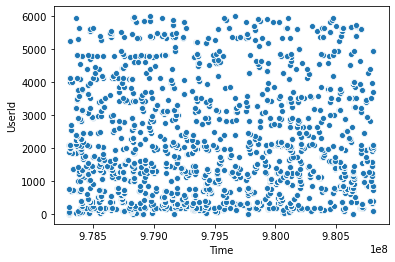

In [49]:
sns.scatterplot(x=tr["Time"], y=tr["UserId"])

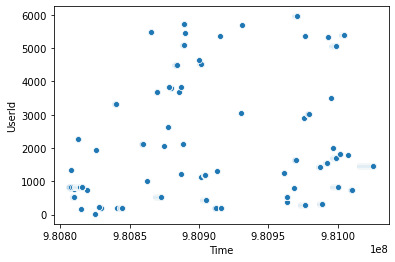

In [50]:
sns.scatterplot(x=val["Time"], y=val["UserId"])

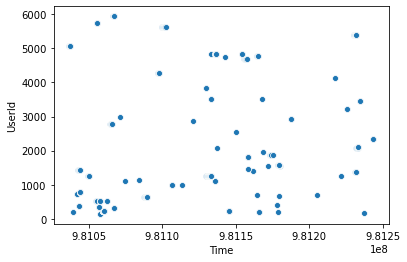

In [51]:
sns.scatterplot(x=test["Time"], y=test["UserId"])

In [52]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [53]:
tr.drop("date", axis=1, inplace=True)
val.drop("date", axis=1, inplace=True)
test.drop("date", axis=1, inplace=True)

In [54]:
tr.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

Pickle 저장

In [55]:
save_path = data_path/'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [56]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum() #누적합
        
        return offsets

In [57]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Time,item_idx
0,1,3186,978300019,0
1,1,1270,978300055,1
2,1,1721,978300055,2
3,1,1022,978300055,3
4,1,2340,978300103,4
5,1,1836,978300172,5
6,1,3408,978300275,6
7,1,2804,978300719,7
8,1,1207,978300719,8
9,1,1193,978300760,9


In [58]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]] # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [59]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=32)
tr_dataset.df.head(15)

,UserId,ItemId,Time,item_idx
0,1,3186,978300019,0
1,1,1270,978300055,1
2,1,1721,978300055,2
3,1,1022,978300055,3
4,1,2340,978300103,4
5,1,1836,978300172,5
6,1,3408,978300275,6
7,1,2804,978300719,7
8,1,1207,978300719,8
9,1,1193,978300760,9


In [60]:
iter_ex = iter(tr_data_loader)

In [61]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  53  67 156 811 226 316 340  45 531 343 154 878  74 648 175 124  97
 668 373 343 727   7 753  11 185 344 760 463 384 808  11]
Label Item Idx are :       [   1   54   68  157  352  227  317  341    7  118  340  537  879 1019
  136  357  346   88  669  721  173    2   41    6   87  758  750  187
  804  517  809  504]
Previous Masked Input Idx are [ 4 12 13 16 26]


In [62]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [63]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [64]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.5, lr=0.001, epochs=50, k=20)

In [65]:
model = create_model(args)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 1, 2713)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      414750    
_________________________________________________________________
dropout (Dropout)            (32, 50)                  0         
_________________________________________________________________
dense (Dense)                (32, 2713)                138363    
Total params: 553,113
Trainable params: 553,113
Non-trainable params: 0
_________________________________________________________________


In [66]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [67]:
train_model(model, args)

Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0, train_loss=7.16]     

	 - Recall@20 epoch 1: 0.125000
	 - MRR@20    epoch 1: 0.019661



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0, train_loss=7.32]     

	 - Recall@20 epoch 2: 0.125000
	 - MRR@20    epoch 2: 0.024279



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0, train_loss=7.16]     

	 - Recall@20 epoch 3: 0.125000
	 - MRR@20    epoch 3: 0.019308



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0, train_loss=7.17]     

	 - Recall@20 epoch 4: 0.156250
	 - MRR@20    epoch 4: 0.026361



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0, train_loss=7.14]     

	 - Recall@20 epoch 5: 0.156250
	 - MRR@20    epoch 5: 0.020549



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0, train_loss=6.86]     

	 - Recall@20 epoch 6: 0.156250
	 - MRR@20    epoch 6: 0.024826



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0, train_loss=7.04]     

	 - Recall@20 epoch 7: 0.125000
	 - MRR@20    epoch 7: 0.021740



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0, train_loss=6.98]     

	 - Recall@20 epoch 8: 0.125000
	 - MRR@20    epoch 8: 0.024138



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0, train_loss=6.87]     

	 - Recall@20 epoch 9: 0.125000
	 - MRR@20    epoch 9: 0.041383



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0, train_loss=6.58]     

	 - Recall@20 epoch 10: 0.125000
	 - MRR@20    epoch 10: 0.043204



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.63] 

	 - Recall@20 epoch 11: 0.125000
	 - MRR@20    epoch 11: 0.044508



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0, train_loss=6.78]     

	 - Recall@20 epoch 12: 0.156250
	 - MRR@20    epoch 12: 0.043180



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.26]

	 - Recall@20 epoch 13: 0.156250
	 - MRR@20    epoch 13: 0.045376



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.0938, train_loss=6.42]

	 - Recall@20 epoch 14: 0.156250
	 - MRR@20    epoch 14: 0.029872



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.83]

	 - Recall@20 epoch 15: 0.125000
	 - MRR@20    epoch 15: 0.031771



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.0938, train_loss=6.34]

	 - Recall@20 epoch 16: 0.156250
	 - MRR@20    epoch 16: 0.067294



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.18]

	 - Recall@20 epoch 17: 0.187500
	 - MRR@20    epoch 17: 0.041383



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.91]

	 - Recall@20 epoch 18: 0.187500
	 - MRR@20    epoch 18: 0.039145



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.156, train_loss=5.35] 

	 - Recall@20 epoch 19: 0.187500
	 - MRR@20    epoch 19: 0.056068



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0, train_loss=5.69]     

	 - Recall@20 epoch 20: 0.156250
	 - MRR@20    epoch 20: 0.042969



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.188, train_loss=5.19] 

	 - Recall@20 epoch 21: 0.187500
	 - MRR@20    epoch 21: 0.037843



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.188, train_loss=5.14] 

	 - Recall@20 epoch 22: 0.187500
	 - MRR@20    epoch 22: 0.035764



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.65]

	 - Recall@20 epoch 23: 0.187500
	 - MRR@20    epoch 23: 0.054334



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.31]

	 - Recall@20 epoch 24: 0.187500
	 - MRR@20    epoch 24: 0.055159



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.219, train_loss=4.43] 

	 - Recall@20 epoch 25: 0.187500
	 - MRR@20    epoch 25: 0.054249



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.219, train_loss=4.91] 

	 - Recall@20 epoch 26: 0.187500
	 - MRR@20    epoch 26: 0.055506



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0, train_loss=4.84]     

	 - Recall@20 epoch 27: 0.187500
	 - MRR@20    epoch 27: 0.050053



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.188, train_loss=4.99] 

	 - Recall@20 epoch 28: 0.218750
	 - MRR@20    epoch 28: 0.035706



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.2]  

	 - Recall@20 epoch 29: 0.218750
	 - MRR@20    epoch 29: 0.035601



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.89] 

	 - Recall@20 epoch 30: 0.187500
	 - MRR@20    epoch 30: 0.050409



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.09] 

	 - Recall@20 epoch 31: 0.187500
	 - MRR@20    epoch 31: 0.049640



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.68] 

	 - Recall@20 epoch 32: 0.187500
	 - MRR@20    epoch 32: 0.036285



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.63] 

	 - Recall@20 epoch 33: 0.187500
	 - MRR@20    epoch 33: 0.050260



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.5]  

	 - Recall@20 epoch 34: 0.187500
	 - MRR@20    epoch 34: 0.049195



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.219, train_loss=4.73] 

	 - Recall@20 epoch 35: 0.187500
	 - MRR@20    epoch 35: 0.034003



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.344, train_loss=4.02] 

	 - Recall@20 epoch 36: 0.187500
	 - MRR@20    epoch 36: 0.033496



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.55]  

	 - Recall@20 epoch 37: 0.187500
	 - MRR@20    epoch 37: 0.049777



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.59]

	 - Recall@20 epoch 38: 0.187500
	 - MRR@20    epoch 38: 0.051916



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.312, train_loss=3.79] 

	 - Recall@20 epoch 39: 0.187500
	 - MRR@20    epoch 39: 0.052968



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.219, train_loss=4.09] 

	 - Recall@20 epoch 40: 0.156250
	 - MRR@20    epoch 40: 0.055826



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.344, train_loss=3.35] 

	 - Recall@20 epoch 41: 0.125000
	 - MRR@20    epoch 41: 0.054167



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.02]

	 - Recall@20 epoch 42: 0.125000
	 - MRR@20    epoch 42: 0.054315



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.02] 

	 - Recall@20 epoch 43: 0.125000
	 - MRR@20    epoch 43: 0.050149



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.156, train_loss=3.8]  

	 - Recall@20 epoch 44: 0.125000
	 - MRR@20    epoch 44: 0.039732



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.07] 

	 - Recall@20 epoch 45: 0.125000
	 - MRR@20    epoch 45: 0.034696



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.23] 

	 - Recall@20 epoch 46: 0.125000
	 - MRR@20    epoch 46: 0.034696



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.344, train_loss=3.44] 

	 - Recall@20 epoch 47: 0.125000
	 - MRR@20    epoch 47: 0.032910



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.12]

	 - Recall@20 epoch 48: 0.125000
	 - MRR@20    epoch 48: 0.032738



Train:   0%|          | 0/533 [00:00<?, ?it/s, accuracy=0.219, train_loss=3.83] 

	 - Recall@20 epoch 49: 0.125000
	 - MRR@20    epoch 49: 0.032352



Evaluation:   2%|▏         | 1/54 [00:00<00:05, 10.39it/s]

	 - Recall@20 epoch 50: 0.125000
	 - MRR@20    epoch 50: 0.032738



In [83]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 32)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   6%|▌         | 1/17 [00:00<00:02,  7.22it/s]

	 - Recall@20: 0.218750
	 - MRR@20: 0.050928



### 정리
  
토이프로젝트에 사용된 데이터셋은 UserId와 영화 정보와 그리고 영화에 대한 평점이다.  
그리고 이 데이터셋에 Time column으로 UTC 타입의 시간 정보가 주어져있다.  
동일한 시간에 여러 영화에 대해 평점을 매긴 userid도 있기때문에 Time이 어떤 기준으로 정의 된건지  
이해하기 어려움이 있었다. 넷플릭스 처럼 한 아이디로 동시접속이 가능한건지 아니면 어떤 오차에 의해서  
근소한 시간차이가 같은 시간으로 입력된 것인지 모르겠지만, 일단 이상치로 판단하지 않고 그대로 학습에  
사용하였다.  
  
노드 예시에서 세션과 무비렌즈 데이터에서 유저 정보를 비교해 보면  
세션Id에서는 익명의 사용자가 웹 상에서 행동한 활동들이 기록되는 것이었고,  
유저Id는 특정 사용자가 영화에 평점을 매긴 정보들이 저장되어 있다.  
  
시간에 따른 세션Id의 활동을 plot해보면 일정 시간이 지나면 새로운 세션들이 생성되는 것을 볼 수 있다.  
반면 무비렌즈에서 UserId를 시간에 따라 plot 해보면 UserId가 등장한 부터는 전 구간에 비교적 꾸준히 고르게  
활동이 나타난다. 물론 특징은 활동을 최초로 시작한 시점에서 최근으로 갈 수록 활동의 빈도가 점점 줄어든다는 경향성이보이고 있다.  
  
이번에 사용할 모델의 목적은 최근의 활동들을 파악해 item을 추천하는 추천시스템을 구축하는 것이다.  
데이터셋 구성을 학습용은 30일 정도, 검증용은 2일, 테스트용은 2일 정도로 잡아서 비율을 맞춰주었다.  
이때 최근날짜를 기준으로 데이터셋을 구성하면 검증, 테스트 데이터셋의 절대적인 양이 작기때문에  
데이터의 초반 날짜 중에서 활동 로그가 많이 남아있는 기간을 찾은 다음 그 기간안에서 데이터셋을 나누었다.  
  
개별 UserId를 하나의 세션으로 정의하였다. 그 이유는 기존에 우리가 알고 있는Session의 정의와 다르게 UserId는 독립적인 한 사람으로 생각할 수 있고 특정 기준(예를 들면 한달 단위로)으로 userId를 묶어서 하나의 세션으로 정의하는 등의 개인의 정보를 집합으로 묶어버리면서 생기는 정보손실이 클 것이라 판단하였기 때문이다.  
  
배치사이즈는 validation set의 UserId 수 보다 작게 하여야 에러없이 학습이 진행되기 때문에 32로 설정하고 epoch은 50으로 수행하였다.  
  
날짜를 다양한 구간으로 잡아보기도 하고, 배치사이즈나 에폭같은 하이퍼파라미터를 조절해보기도 하며 모델의 학습 성능을 관찰 하였다.